<a href="https://colab.research.google.com/github/brunaafl/EEG_EA-Domain-Adap/blob/main/exp1_braindecode%2Bmoabb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne moabb braindecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 26.3 MB/s eta 0:00:00
  Created wheel for pyriemann: filename=pyriemann-0.4-py2.py3-none-any.whl size=105118 sha256=5ea5d8cde40ed3e59f72fe4f7495a1552e6c05de6996792283699d20b6a0c3b0
  Stored in directory: /root/.cache/pip/wheels/1a/32/b8/6f844cc26ba42daee387f6aacc4b80f128233ff84703380967
Successfully built pyriemann


In [ ]:
import os.path as osp

import matplotlib.pyplot as plt
import mne
import seaborn as sns
import torch
import copy

from braindecode import EEGClassifier
from braindecode.datasets import create_from_X_y
from braindecode.models import ShallowFBCSPNet, EEGNetv4
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from braindecode.preprocessing import preprocess, Preprocessor

from moabb.datasets import BNCI2014001, PhysionetMI
from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import LeftRightImagery
from moabb.utils import set_download_dir

import numpy as np
from numpy import unique, iscomplexobj, real, any, isfinite
from scipy.linalg import sqrtm, inv

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline


In [ ]:
set_download_dir(osp.join(osp.expanduser("~"), "mne_data"))

The path given does not exist, creating it..
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


# Euclidean Alignment as a transformation

In [ ]:
class EuclideanAlignment:
    """
    https://github.com/mcd4874/NeurIPS_competition/blob/4df1f222929e9824a55c9c4ae6634743391b0fe9/EEG_Lightning/dassl/data/datasets/data_util.py#L218
    convert trials of each subject to a new format with Euclidean Alignment technique
    https://arxiv.org/pdf/1808.05464.pdf
    """

    # Define Attributes
    def __init__(self, metadata, list_r_op=None,subject_ids=None):
      # list_r_op : list of each individual's reference matrix
        self.groups = metadata.subject.values
        self.runs = metadata.run.values
        self.list_r_op = list_r_op
        if subject_ids is not None:
            update_list_r_op = [self.list_r_op[subject_id] for subject_id in subject_ids]
            print("only use r-op for subjects {}".format(subject_ids))
            self.list_r_op = update_list_r_op

    # Calculate ref matrix
    def calculate_r_op(self,data):

        assert len(data.shape) == 3

        # compute mean covariance
        r = 0
        for trial in data:
            cov = np.cov(trial, rowvar=True)
            r += cov

        r = r/data.shape[0]

        if np.iscomplexobj(r):
            print("covariance matrix problem")
        if np.iscomplexobj(sqrtm(r)):
            print("covariance matrix problem sqrt")

        # compute ^-1/2
        r_op = inv(sqrtm(r))

        if np.iscomplexobj(r_op):
            print("WARNING! Covariance matrix was not SPD somehow. Can be caused by running ICA-EOG rejection, if "
                  "not, check data!!")
            r_op = np.real(r_op).astype(np.float64)
        elif not np.any(np.isfinite(r_op)):
            print("WARNING! Not finite values in R Matrix")
        return r_op

    # Matrix multiplication
    def convert_trials(self,data,r_op):
        results = np.matmul(r_op, data)
        return results

    # reference matrix for each subject
    def generate_list_r_op(self,subjects_data):
        list_r_op = list()
        for subject_idx in range(len(subjects_data)):
            subject_data = subjects_data[subject_idx]
            r_op = self.calculate_r_op(subject_data)
            list_r_op.append(r_op)
        return list_r_op

    # Apply the EA in all data
    def convert_all_data_with_EA(self,subjects_data):
        #calculate r_op for each subject (or run)
        
        if self.list_r_op is not None:
            assert len(self.list_r_op) == len(subjects_data)
            print("use exist r_op")

        else:
            print("generate new r_op")
            self.list_r_op = self.generate_list_r_op(subjects_data)

        new_data = list()

        for subject_idx in range(len(subjects_data)):

            subject_data = subjects_data[subject_idx]
            r_op = self.list_r_op[subject_idx]
            subject_data = self.convert_trials(subject_data,r_op)
            new_data.append(subject_data)

        return new_data

    # Apply the EA on subject_data
    def convert_subject_data_with_EA(self, subject_data):
        # calculate r_op for a subject (or run)
        r_op = self.calculate_r_op(subject_data)
        subject_data = self.convert_trials(subject_data,r_op)
        return subject_data, r_op

    # Apply the EA on a dataset on each run from all subjects
    def apply_EA(self, X, subjects_idx, n_runs):
      
      concat=[]; r_op_list=[]

      for subj in subjects_idx:
        print(f"Subject {subj}")
        X_subj, r_op = self.apply_EA_subj( X, subj, n_runs = n_runs )
        concat.append(X_subj)
        r_op_list.append(r_op)

      X_EA=np.concatenate(concat)

      return X_EA, r_op_list

    # Apply the EA on a subject
    def apply_EA_subj(self, X, subj, separate_runs = True, n_runs=None, run=None):

      data_subj = self.groups==subj

      #If we want to align each run
      if separate_runs == True:
        if run is None:
          concat=[]; r_op_list = []

          for k in range(n_runs):
            A = self.runs
            data_runs = A==f'run_{k}'
            intersec = np.logical_and(data_subj, data_runs)
            X_aux = copy.deepcopy(X[intersec])
            X_aux_EA, r_op = self.convert_subject_data_with_EA(X_aux)
            concat.append(X_aux_EA)

          X_EA = np.concatenate(concat)
          r_op_list.append(r_op)

        else:
          data_runs = self.runs==f'run_{run}'

          intersec = np.logical_and(data_subj, data_runs)
          X_aux = copy.deepcopy(X[intersec])
          X_EA, r_op_list = self.convert_subject_data_with_EA(X_aux)
      
      else:
        X_subj = X[data_subj]
        X_EA, r_op = self.convert_subject_data_with_EA(X_subj)

      return X_EA, r_op_list



In [ ]:
import numpy as np 
from scipy.linalg import sqrtm, inv
from numpy import iscomplexobj, real, any, isfinite
### Define this as Transformation, maybe...
def euclidean_alignment(data, y=None):

  data_EA=copy.deepcopy(data)

  assert len(data.shape) == 3

  print(len(data))

  r = 0
  for trial in data:
    cov = np.cov(trial, rowvar=True)
    r += cov

  r = r/len(data)

  if iscomplexobj(r):
    print("covariance matrix problem")
  if iscomplexobj(sqrtm(r)):
    print("covariance matrix problem sqrt")

  r_op = inv(sqrtm(r))

  if iscomplexobj(r_op):
    print("WARNING! Covariance matrix was not SPD somehow. "+
            "Can be caused by running ICA-EOG rejection, if "+
            "not, check data!!")
    r_op = real(r_op).astype(np.float64)
  elif not any(isfinite(r_op)):
    print("WARNING! Not finite values in R Matrix")

  result = np.matmul(r_op, data)

  return result


# dataset_EA = preprocess(dataset,[Preprocessor(euclidean_alignment,apply_on_array=True)])


In [ ]:
def split_runs_EA(X,rpc, n_classes):
  X_aux = []
  m = rpc*n_classes
  n = X.shape[0]
  for k in range(int(n/m)):
    run = X[k*m:(k+1)*m]
    run_EA = euclidean_alignment(run)
    X_aux.append(run_EA)
  X_EA = np.concatenate(X_aux)
  return X_EA
  

The Cross-Subject Evaluation divides the test individual's sessions? How to use both?

In [ ]:
i=0
A = runs==f'run_{i}'
B = groups==1
C = np.logical_and(A,B)
B

array([ True,  True,  True, ..., False, False, False])

In [ ]:
groups = metadata.subject.values
sessions = metadata.session.values
runs = metadata.run.values
subjects_idx =dataset_a.subject_list
n_runs = 6
EA = EuclideanAlignment(metadata)
X_EA,_ = EA.apply_EA(X, subjects_idx, n_runs)

Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9


In [ ]:
X_EA

In [ ]:
X

# Load datasets

In [ ]:
# Define Evaluation
paradigm = LeftRightImagery()
# Because this is being auto-generated we only use 2 subjects
dataset_a = BNCI2014001()
dataset_b = PhysionetMI(imagined=True)

#dataset.subject_list = dataset.subject_list[:9]
# Por que criamos essa lista datasets? 
# Fazendo isso os modelos vao ser criados entre os proprios datasets ou vai misturar?
datasets = [dataset_a]

To obtain the number of channels and input windows samples, can we hard-code with the right paramethers (that are known) or do we need to extract them?

In [ ]:
X, y, metadata = paradigm.get_data(dataset_a)

 75%|███████████████████████████▊         | 31.4M/41.7M [00:13<00:00, 41.3MB/s]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A04E.mat' to file '/root/mne_data/MNE-bnci-data/database/data-sets/001-2014/A04E.mat'.

  0%|                                              | 0.00/41.7M [00:00<?, ?B/s]
  1%|▏                                     | 209k/41.7M [00:00<00:20, 1.99MB/s]
  7%|██▋                                  | 2.97M/41.7M [00:00<00:02, 16.8MB/s]
 23%|████████▍                            | 9.49M/41.7M [00:00<00:00, 38.6MB/s]
 39%|██████████████▎                      | 16.1M/41.7M [00:00<00:00, 49.6MB/s]
 55%|████████████████████▏                | 22.8M/41.7M [00:00<00:00, 55.5MB/s]
 72%|██████████████████████████▌          | 30.0M/41.7M [00:00<00:00, 61.3MB/s]
 87%|████████████████████████████████     | 36.1M/41.7M [00:00<00:00, 60.3MB/s]
100%|█████████████████████████████████████| 41.7M/41.7M [00:00<00:00, 7.65GB/s]
SHA256 hash of downloaded file: 81

In [ ]:
X[:24].shape

(24, 22, 1001)

In [ ]:
def split_runs(X,rpc, n_classes):
  X_aux = []
  m = rpc*n_classes
  n = X.shape[0]
  for k in range(int(n/m)):
    run = X[k*m:(k+1)*m]
    run_EA = euclidean_alignment(run)
    X_aux.append(run_EA)
  X_EA = np.concatenate(X_aux)
  return X_EA
  

In [ ]:
X_EA = split_runs(X, 12, 2)

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24


In [ ]:
X.shape

(2592, 22, 1001)

In [ ]:
2592/9

288.0

In [ ]:
(2592/9)/2

144.0

In [ ]:
type(X)

numpy.ndarray

In [ ]:
type(metadata)

pandas.core.frame.DataFrame

# Create model and classifier

Some doubts: thw 2 datasets we'rw using have different number of channels and classes. How do we define the number of channels we're going to use?? How to select the channels?

* Tem como definir uma sequência? Tipo, primeiro cria e avalia p/ BBNCI201400 e depois p Physionet?

In [ ]:
def set_det_device():
  cuda = (
      torch.cuda.is_available()
  )  # check if GPU is available, if True chooses to use it
  device = "cuda" if cuda else "cpu"
  if cuda:
      torch.backends.cudnn.benchmark = True
  seed = 20200220  # random seed to make results reproducible
  # Set random seed to be able to reproduce results
  set_random_seeds(seed=seed, cuda=cuda)
  return device

In [ ]:
cuda = (
    torch.cuda.is_available()
)  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2

# hard-coded for now
# How to adjust??
# PARAMETHERS FOR THE BBNCI2014001 DATASET
n_chans = 22
input_window_samples = 1001

'''
# PARAMETHERS FOR THE PHYSIONET DATASET
n_chans = 64
input_window_samples = 481
'''

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    drop_prob=0.5
)


# Send model to GPU
if cuda:
    model.cuda()

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

batch_size = 64
n_epochs = 100

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
)

/usr/local/lib/python3.8/dist-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


Idea: (since some parameters are different for different datasets)

In [ ]:
def init_model( n_chans, n_classes, input_window_samples):
  model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    drop_prob=0.5
  )
  return model

# Define pipeline

Why is it important? Define sequence of transformations

Can we use the make_pipeline func?

In [ ]:
class TransformaParaWindowsDataset(BaseEstimator, TransformerMixin):
    def __init__(self, kw_args=None):
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.y = y
        # self.X = euclidean_alignment(X.get_data())
        return self

    def transform(self, X, y=None ):

        #X_EA = split_runs(X.get_data(), 12, 2)

        dataset = create_from_X_y(
            X=X.get_data(),
            #X=X_EA,
            y=self.y,
            window_size_samples=X.get_data().shape[2],
            window_stride_samples=X.get_data().shape[2],
            drop_last_window=False,
            sfreq=X.info["sfreq"],
        )

        # dataset_EA = preprocess(dataset,[Preprocessor(euclidean_alignment,apply_on_array=True)])

        return dataset

    def __sklearn_is_fitted__(self):
        """Return True since Transfomer is stateless."""
        return True

class TransformaParaWindowsDatasetEA(BaseEstimator, TransformerMixin):
    def __init__(self, kw_args=None):
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.y = y
        # self.X = euclidean_alignment(X.get_data())
        return self

    def transform(self, X, y=None ):

        X_EA = split_runs_EA(X.get_data(), 12, 2)

        dataset = create_from_X_y(
            X=X_EA,
            y=self.y,
            window_size_samples=X.get_data().shape[2],
            window_stride_samples=X.get_data().shape[2],
            drop_last_window=False,
            sfreq=X.info["sfreq"],
        )

        # dataset_EA = preprocess(dataset,[Preprocessor(euclidean_alignment,apply_on_array=True)])

        return dataset

    def __sklearn_is_fitted__(self):
        """Return True since Transfomer is stateless."""
        return True

create_dataset = TransformaParaWindowsDataset()


In [ ]:
class ClassifierModel(BaseEstimator, ClassifierMixin):
    def __init__(self, clf, kw_args=None):
        self.clf = clf
        self.classes_ = None
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.clf.fit(X, y=y, **self.kw_args)
        self.classes_ = unique(y)

        return self.clf

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


fit_params = {"epochs": 100}

brain_clf = ClassifierModel(clf, fit_params)


In [ ]:
pipe = Pipeline([("Braindecode_dataset", create_dataset), 
                 ("Net", brain_clf)])
print(pipe)
pipes = {}
pipes["EEGNetv4"] = pipe

Pipeline(steps=[('Braindecode_dataset', TransformaParaWindowsDataset()),
                ('Net',
                 ClassifierModel(clf=<class 'braindecode.classifier.EEGClassifier'>[uninitialized](
  module=EEGNetv4(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=_transpose_to_b_1_c_0) 
    (conv_temporal): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (bnorm_tem...
    (elu_2): Expression(expression=elu) 
    (pool_2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(16, 2, kernel_size=(1, 31), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (permute_back): Expression(expression=_transpose_1_0) 
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
),
                                 kw_args={'epochs': 100}))])


# **Some tests with paradigm methods**

How can I use this to separate X_trains?

In [ ]:
a=np.array([1,2])
b=np.array([3,4])
c=np.concatenate([a,b])
c

array([1, 2, 3, 4])

In [ ]:
paradigm = LeftRightImagery()
# Because this is being auto-generated we only use 2 subjects
dataset = BNCI2014001()
dataset_b = PhysionetMI(imagined=True)

In [ ]:
X.shape

(2592, 22, 1001)

In [ ]:
X, y, metadata = paradigm.get_data(dataset_a)

/usr/local/lib/python3.8/dist-packages/moabb/datasets/download.py:53: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


100%|█████████████████████████████████████| 42.8M/42.8M [00:00<00:00, 29.8GB/s]
SHA256 hash of downloaded file: 054f02e70cf9c4ada1517e9b9864f45407939c1062c6793516585c6f511d0325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.8M/43.8M [00:00<00:00, 24.1GB/s]
SHA256 hash of downloaded file: 53d415f39c3d7b0c88b894d7b08d99bcdfe855ede63831d3691af1a45607fb62
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.1M/43.1M [00:00<00:00, 30.2GB/s]
SHA256 hash of downloaded file: 5ddd5cb520b1692c3ba1363f48d98f58f0e46f3699ee50d749947950fc39db27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████

In [ ]:
dataset_b.subject_list=subj = list(range(1,4))

In [ ]:
Xb, yb, metadatab = paradigm.get_data(dataset_b)

100%|█████████████████████████████████████| 2.60M/2.60M [00:00<00:00, 1.85GB/s]
SHA256 hash of downloaded file: 7d0732eea963488a53153835524e55c2b68220b0a0c7c5be99e535a9f5367e7f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 2.60M/2.60M [00:00<00:00, 2.05GB/s]
SHA256 hash of downloaded file: 0f50978bb972e693b8c758a9223a2d9fa35c7f117226391090bcc32a83ce765d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|██████████████████████████████████████| 2.60M/2.60M [00:00<00:00, 995MB/s]
SHA256 hash of downloaded file: bbf7137bfa7905724741e95359fa090439d4422c07bdba16c792acb09ebd6421
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████

In [ ]:
Xb.shape

(135, 64, 481)

(90, 64, 481)

In [ ]:
dataset

X.shape = (a,b,c)

a : epochs (number of trials)

b : channels 

c : time sample 

If the number of channels and time samples of each dataset are different, how can I define the model? 

In [ ]:
X.shape

In [ ]:
X_b.shape

In [ ]:
metadata

,subject,session,run
0,1,session_T,run_0
1,1,session_T,run_0
2,1,session_T,run_0
3,1,session_T,run_0
4,1,session_T,run_0
...,...,...,...
2587,9,session_E,run_5
2588,9,session_E,run_5
2589,9,session_E,run_5
2590,9,session_E,run_5


In [ ]:
groups = metadata.subject.values
sessions = metadata.session.values
runs = metadata.run.values
n_subjects = len(dataset_a.subject_list)

In [ ]:
import copy

def X_subj(X,subj,run=None):
  data_subj = groups==subj

  if run is None:
    for k in range(6):
      data_runs = runs==f'run_{k}'

      intersec = np.logical_and(data_subj, data_runs)
      X_aux = copy.deepcopy(X[intersec])

  else:
    data_runs = runs==f'run_{run}'

    intersec = np.logical_and(data_subj, data_runs)
    X_aux = copy.deepcopy(X[intersec])

  return X_aux
X_subj_0 = X_subj(X,1,0)
X_subj_1 = X_subj(X,1,1)

In [ ]:
X_a = np.concatenate([X_subj_0, X_subj_1])

In [ ]:
X_a.shape

(96, 22, 1001)

In [ ]:
X_subj

In [ ]:
EA = EuclideanAlignment()
X_EA = EA.convert_subject_data_with_EA(X_subj)
X_EA

In [ ]:
groups

array([1, 1, 1, ..., 9, 9, 9])

In [ ]:
sessions

array(['session_T', 'session_T', 'session_T', ..., 'session_E',
       'session_E', 'session_E'], dtype=object)

In [ ]:
runs

array(['run_0', 'run_0', 'run_0', ..., 'run_5', 'run_5', 'run_5'],
      dtype=object)

In [ ]:
A=runs=='run_0'

In [ ]:
B=groups==1

In [ ]:
len(B)

2592

In [ ]:
len(A)

2592

In [ ]:
C=np.logical_and(A,B)
len(C)

2592

In [ ]:
X[groups==1]

array(['run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0',
       'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0',
       'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0',
       'run_0', 'run_0', 'run_0'], dtype=object)

In [ ]:
X[metadata.subject.values==1]

array([[[  6.12675343,   4.80069492,   1.8937593 , ...,  -1.80963356,
          -0.95822005,   0.10018214],
        [  5.58056783,   3.78074325,   1.02786715, ...,  -1.32946883,
          -0.62293255,   0.06768451],
        [  7.43279059,   5.46171881,   2.11057866, ...,  -0.57576039,
          -0.65376666,  -0.73565678],
        ...,
        [  7.465582  ,   3.39468294,  -1.15504664, ...,  -3.41820391,
          -2.94795975,  -2.31999583],
        [  5.00811146,   1.58727604,  -2.11582106, ...,  -3.48512891,
          -2.69524861,  -1.68924441],
        [  8.01582351,   4.2274779 ,  -0.1410632 , ...,  -4.097163  ,
          -3.54158428,  -2.65380789]],

       [[ -0.7702083 ,  -0.77995427,  -1.51378905, ...,  -9.44448146,
         -11.03344346, -11.02605606],
        [ -1.33536169,  -1.04522174,  -0.87003607, ...,  -8.77443588,
         -10.72309939, -10.2110244 ],
        [  0.30316772,   0.02742408,  -1.01425588, ...,  -9.24718849,
         -11.26148117, -10.91802947],
        ...,


# Train

Using LOO cross-validation

In [ ]:
mne.set_log_level(False)

overwrite = True  # set to True if we want to overwrite cached results
evaluation = CrossSubjectEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    suffix="braindecode_example",
    overwrite=overwrite,
    return_epochs=True,
)

results = evaluation.process(pipes)

print(results.head())


/usr/local/lib/python3.8/dist-packages/moabb/analysis/results.py:79: RuntimeWarning: Setting non-standard config type: "MOABB_RESULTS"
  set_config("MOABB_RESULTS", osp.join(osp.expanduser("~"), "mne_data"))

001-2014-CrossSubject:   0%|          | 0/9 [00:00<?, ?it/s]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24


 75%|███████████████████████████▊         | 31.4M/41.7M [23:14<07:37, 22.5kB/s]


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5282        0.7447  0.0006  9.3816
      2            0.5373        0.7236  0.0006  2.2553
      3            0.5408        0.7156  0.0006  2.2856
      4            0.5482        0.7057  0.0006  2.3949
      5            0.5625        0.6961  0.0006  2.2806
      6            0.5781        0.6967  0.0006  2.3678
      7            0.5998        0.6917  0.0006  2.2991
      8            0.6202        0.6927  0.0006  2.2635
      9            0.6424        0.6842  0.0006  2.2886
     10            0.6623        0.6717  0.0006  2.3577
     11            0.6562        0.6681  0.0006  2.3373
     12            0.6636        0.6595  0.0006  2.3300
     13            0.6667        0.6521  0.0006  2.3712
     14            0.6693        0.6461  0.0006  2.3872
     15            0.6871        0.6331  0.0006  2.3570
     16            0.7196        0.6192  0.0006 


001-2014-CrossSubject:  11%|█         | 1/9 [07:02<56:18, 422.28s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5130        0.7415  0.0006  2.4550
      2            0.5391        0.7330  0.0006  2.3102
      3            0.5404        0.7115  0.0006  2.3159
      4            0.5473        0.7061  0.0006  2.3145
      5            0.5521        0.7021  0.0006  2.2768
      6            0.5660        0.7009  0.0006  2.3241
      7            0.5734        0.6939  0.0006  2.3513
      8            0.5998        0.6830  0.0006  2.3565
      9            0.6363        0.6896  0.0006  2.2888
     10            0.6549        0.6816  0.0006  2.2897
     11            0.6658        0.6691 


001-2014-CrossSubject:  22%|██▏       | 2/9 [13:52<48:25, 415.06s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5174        0.7568  0.0006  2.3126
      2            0.5395        0.7262  0.0006  2.2998
      3            0.5586        0.7170  0.0006  2.3105
      4            0.5508        0.7075  0.0006  2.3215
      5            0.5651        0.6954  0.0006  2.3172
      6            0.5720        0.6948  0.0006  2.2546
      7            0.5907        0.6984  0.0006  2.2325
      8            0.5964        0.6813  0.0006  2.2930
      9            0.6306        0.6802  0.0006  2.2378
     10            0.6484        0.6728  0.0006  2.2515
     11            0.6645        0.6805 


001-2014-CrossSubject:  33%|███▎      | 3/9 [20:38<41:05, 410.86s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5221        0.7530  0.0006  2.2779
      2            0.5347        0.7302  0.0006  2.1937
      3            0.5443        0.7217  0.0006  2.2867
      4            0.5460        0.7037  0.0006  2.2433
      5            0.5534        0.6976  0.0006  2.2795
      6            0.5742        0.6947  0.0006  2.2859
      7            0.5951        0.6839  0.0006  2.2771
      8            0.6202        0.6860  0.0006  2.2230
      9            0.6372        0.6839  0.0006  2.2372
     10            0.6536        0.6716  0.0006  2.2596
     11            0.6771        0.6625 


001-2014-CrossSubject:  44%|████▍     | 4/9 [27:23<34:03, 408.77s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5156        0.7490  0.0006  2.2674
      2            0.5356        0.7329  0.0006  2.2222
      3            0.5460        0.7109  0.0006  2.1385
      4            0.5421        0.7060  0.0006  2.2626
      5            0.5525        0.7039  0.0006  2.1919
      6            0.5673        0.6902  0.0006  2.2699
      7            0.5859        0.6876  0.0006  2.2742
      8            0.6011        0.6852  0.0006  2.1799
      9            0.6432        0.6804  0.0006  2.1295
     10            0.6649        0.6773  0.0006  2.3013
     11            0.6797        0.6751 


001-2014-CrossSubject:  56%|█████▌    | 5/9 [34:05<27:05, 406.30s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5321        0.7501  0.0006  2.3652
      2            0.5490        0.7210  0.0006  2.2757
      3            0.5434        0.7138  0.0006  2.2827
      4            0.5386        0.7102  0.0006  2.2868
      5            0.5469        0.6976  0.0006  2.2635
      6            0.5690        0.6917  0.0006  2.2282
      7            0.5799        0.6783  0.0006  2.3437
      8            0.6159        0.6811  0.0006  2.2291
      9            0.6510        0.6833  0.0006  2.2164
     10            0.6688        0.6733  0.0006  2.1933
     11            0.6775        0.6636 


001-2014-CrossSubject:  67%|██████▋   | 6/9 [40:53<20:20, 406.95s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5200        0.7494  0.0006  2.4716
      2            0.5339        0.7384  0.0006  2.2754
      3            0.5391        0.7148  0.0006  2.2438
      4            0.5486        0.7055  0.0006  2.3709
      5            0.5603        0.6996  0.0006  2.2359
      6            0.5846        0.7017  0.0006  2.2821
      7            0.6094        0.6849  0.0006  2.3654
      8            0.6211        0.6931  0.0006  2.2241
      9            0.6311        0.6791  0.0006  2.3077
     10            0.6471        0.6760  0.0006  2.4314
     11            0.6762        0.6744 


001-2014-CrossSubject:  78%|███████▊  | 7/9 [47:41<13:34, 407.20s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5226        0.7478  0.0006  2.2861
      2            0.5339        0.7202  0.0006  2.2276
      3            0.5421        0.7088  0.0006  2.2819
      4            0.5443        0.7014  0.0006  2.2019
      5            0.5538        0.7043  0.0006  2.3374
      6            0.5703        0.6950  0.0006  2.3103
      7            0.5859        0.6927  0.0006  2.2927
      8            0.6120        0.6852  0.0006  2.2724
      9            0.6428        0.6829  0.0006  2.2993
     10            0.6571        0.6804  0.0006  2.2252
     11            0.6688        0.6733 


001-2014-CrossSubject:  89%|████████▉ | 8/9 [54:33<06:48, 408.83s/it]

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5022        0.7504  0.0006  2.2639
      2            0.5187        0.7187  0.0006  2.4518
      3            0.5412        0.7222  0.0006  2.2397
      4            0.5642        0.7072  0.0006  2.2191
      5            0.5738        0.6959  0.0006  2.3077
      6            0.5859        0.6954  0.0006  2.1737
      7            0.5998        0.6979  0.0006  2.2653
      8            0.6159        0.6996  0.0006  2.2751
      9            0.6241        0.6863  0.0006  2.2487
     10            0.6458        0.6854  0.0006  2.3005
     11            0.6580        0.6858 


001-2014-CrossSubject: 100%|██████████| 9/9 [1:01:24<00:00, 409.35s/it]

      score        time  samples subject    session  channels  n_sessions  \
0  0.955054  420.054993   2304.0       1  session_E        22           2   
1  0.933642  420.054993   2304.0       1  session_T        22           2   
2  0.658372  407.816681   2304.0       2  session_E        22           2   
3  0.686535  407.816681   2304.0       2  session_T        22           2   
4  0.994213  403.644745   2304.0       3  session_E        22           2   

    dataset  pipeline  
0  001-2014  EEGNetv4  
1  001-2014  EEGNetv4  
2  001-2014  EEGNetv4  
3  001-2014  EEGNetv4  
4  001-2014  EEGNetv4  


--------------------------------------------------------

With EA (each run aligned separately)

In [ ]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.955054,420.054993,2304.0,1,session_E,22,2,001-2014,EEGNetv4
1,0.933642,420.054993,2304.0,1,session_T,22,2,001-2014,EEGNetv4
2,0.658372,407.816681,2304.0,2,session_E,22,2,001-2014,EEGNetv4
3,0.686535,407.816681,2304.0,2,session_T,22,2,001-2014,EEGNetv4
4,0.994213,403.644745,2304.0,3,session_E,22,2,001-2014,EEGNetv4
5,0.995563,403.644745,2304.0,3,session_T,22,2,001-2014,EEGNetv4
6,0.740934,403.434692,2304.0,4,session_E,22,2,001-2014,EEGNetv4
7,0.742091,403.434692,2304.0,4,session_T,22,2,001-2014,EEGNetv4
8,0.690008,399.672546,2304.0,5,session_E,22,2,001-2014,EEGNetv4
9,0.664352,399.672546,2304.0,5,session_T,22,2,001-2014,EEGNetv4


--------------------------------------------------------

With EA

In [ ]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.934606,399.624969,2304.0,1,session_E,22,2,001-2014,EEGNetv4
1,0.895640,399.624969,2304.0,1,session_T,22,2,001-2014,EEGNetv4
2,0.665123,391.592560,2304.0,2,session_E,22,2,001-2014,EEGNetv4
3,0.613233,391.592560,2304.0,2,session_T,22,2,001-2014,EEGNetv4
4,0.994792,399.454865,2304.0,3,session_E,22,2,001-2014,EEGNetv4
5,1.000000,399.454865,2304.0,3,session_T,22,2,001-2014,EEGNetv4
6,0.745563,392.364624,2304.0,4,session_E,22,2,001-2014,EEGNetv4
7,0.825039,392.364624,2304.0,4,session_T,22,2,001-2014,EEGNetv4
8,0.615162,387.606293,2304.0,5,session_E,22,2,001-2014,EEGNetv4
9,0.544367,387.606293,2304.0,5,session_T,22,2,001-2014,EEGNetv4


--------------------------------------------------------

Without EA (9 subj)

In [ ]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.824267,423.722626,2304.0,1,session_E,22,2,001-2014,EEGNetv4
1,0.714313,423.722626,2304.0,1,session_T,22,2,001-2014,EEGNetv4
2,0.681520,408.085541,2304.0,2,session_E,22,2,001-2014,EEGNetv4
3,0.550733,408.085541,2304.0,2,session_T,22,2,001-2014,EEGNetv4
4,0.826389,414.177429,2304.0,3,session_E,22,2,001-2014,EEGNetv4
5,0.834298,414.177429,2304.0,3,session_T,22,2,001-2014,EEGNetv4
6,0.591821,413.088501,2304.0,4,session_E,22,2,001-2014,EEGNetv4
7,0.718557,413.088501,2304.0,4,session_T,22,2,001-2014,EEGNetv4
8,0.531829,417.204132,2304.0,5,session_E,22,2,001-2014,EEGNetv4
9,0.462191,417.204132,2304.0,5,session_T,22,2,001-2014,EEGNetv4


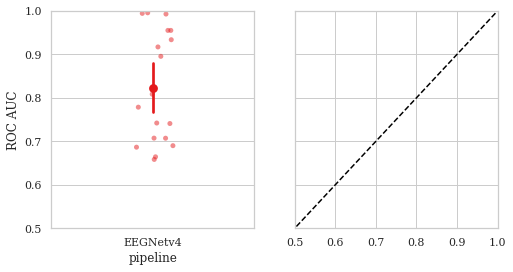

In [ ]:

##############################################################################
# Plot Results
# ----------------
#
# Here we plot the results. We the first plot is a pointplot with the average
# performance of each pipeline across session and subjects.
# The second plot is a paired scatter plot. Each point representing the score
# of a single session. An algorithm will outperforms another is most of the
# points are in its quadrant.

fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(
    data=results, y="score", x="pipeline", ax=axes[0], zorder=1, palette="Set1"
)

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

# paired plot
paired = results.pivot_table(
    values="score", columns="pipeline", index=["subject", "session"]
)
paired = paired.reset_index()

axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)

plt.show()